In [1]:
from ophyd import Device, EpicsMotor, EpicsSignal, EpicsSignalRO
from ophyd import Component as Cpt
import time
import pandas as pd
import numpy as np
from ophyd.sim import det4, noisy_det, motor  # simulated detector, motor
import h5py
from datetime import datetime

import bluesky.plan_stubs as bps
from bluesky.plans import count

import matplotlib.pyplot as plt
import glob

In [2]:
#%matplotlib widget
%matplotlib inline
#%matplotlib notebook

In [2]:
from bluesky import RunEngine
import bluesky.plan_stubs as bps
from bluesky.plans import count, scan
RE = RunEngine({})

In [4]:
## Prepare Live Visualization
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

# Make plots update live while scans run.
# from bluesky.utils import install_kicker
# install_kicker()
#%matplotlib notebook
#from bluesky.utils import install_nb_kicker
#install_nb_kicker()


## Prepare Data Storage
from databroker import Broker
db = Broker.named('xpd')
                  
# from databroker import catalog
# db = catalog['xpd']
    
# Insert all metadata/data captured into db.
RE.subscribe(db.insert)


## Add a Progress Bar
from bluesky.utils import ProgressBarManager
RE.waiting_hook = ProgressBarManager()


OBJECT CACHE: Will use up to 40_490_850_508 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 40_490_850_508 bytes (15% of total physical RAM)


In [5]:
RE(count([det4], num=1))



Transient Scan ID: 1     Time: 2022-11-07 15:12:39
Persistent Unique Scan ID: '9a76adfb-a8ae-42a3-8770-2ea381312373'


Transient Scan ID: 1     Time: 2022-11-07 15:12:39
Persistent Unique Scan ID: '9a76adfb-a8ae-42a3-8770-2ea381312373'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |       det4 |
+-----------+------------+------------+
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |       det4 |
+-----------+------------+------------+
|         1 | 15:12:39.2 |      1.000 |
|         1 | 15:12:39.2 |      1.000 |
+-----------+------------+------------+
generator count ['9a76adfb'] (scan num: 1)



+-----------+------------+------------+
generator count ['9a76adfb'] (scan num: 1)





('9a76adfb-a8ae-42a3-8770-2ea381312373',)

In [12]:
def reset_pumps(pump_list, clear=True, update = '.2 second'):
    for pump in pump_list:
        pump.initialize_pump(clear=clear, update = update)
        pump.infuse_rate_unit.put('ul/min', wait=True)
        pump.infuse_rate.put(100, wait=True)
        pump.withdraw_rate_unit.put('ul/min', wait=True)
        pump.withdraw_rate.put(100, wait=True)
        pump.target_vol_unit.put('ml', wait=True)
        pump.target_vol.put(20, wait=True)
        
        
def reset_pumps2(pump_list, clear=True, update = '.2 second'):
    for pump in pump_list:
        pump.initialize_pump(clear=clear, update = update)
        yield from bps.mv(pump.infuse_rate_unit, 'ul/min', 
                          pump.infuse_rate, 100, 
                          pump.withdraw_rate_unit, 'ul/min', 
                          pump.withdraw_rate, 100, 
                          pump.target_vol_unit, 'ml', 
                          pump.target_vol, 20)


def show_pump_status(syringe_list, pump_list, precursor_list, wait=False):
    for input_size, pump, precursor in zip(syringe_list, pump_list, precursor_list):
        print('Name: ' + f'{pump.name}')
        print('Precursor: ' + f'{precursor}')
        pump.check_pump_condition(input_size, wait=wait)
        print('\n')
        

def set_group_infuse(syringe_list, pump_list, target_vol_list=['50 ml', '50 ml'], rate_list = ['100 ul/min', '100 ul/min']):
    for i, j, k, l in zip(pump_list, target_vol_list, infuse_rate_list, syringe_list):
        vol = float(j.split(' ')[0])
        vol_unit = j.split(' ')[1]
        rate = float(k.split(' ')[0])
        rate_unit = k.split(' ')[1]        
        yield from i.set_infuse(l, target_vol = vol, target_unit = vol_unit, infuse_rate = rate, infuse_unit = rate_unit)
        
def set_group_withdraw(syringe_list, pump_list, target_vol_list=['50 ml', '50 ml'], rate_list = ['100 ul/min', '100 ul/min']):
    for i, j, k, l in zip(pump_list, target_vol_list, rate_list, syringe_list):
        vol = float(j.split(' ')[0])
        vol_unit = j.split(' ')[1]
        rate = float(k.split(' ')[0])
        rate_unit = k.split(' ')[1]        
        yield from i.set_withdraw(l, target_vol = vol, target_unit = vol_unit, withdraw_rate = rate, withdraw_unit = rate_unit)


def start_group_infuse(pump_list):
    for pump in pump_list:
        yield from pump.infuse_pump2()
        

def start_group_withdraw(pump_list):
    for pump in pump_list:
        yield from pump.withdraw_pump2()
        

def stop_group(pump_list):
    for pump in pump_list:
        yield from pump.stop_pump2()
        


def _readable_time(unix_time):
    from datetime import datetime
    dt = datetime.fromtimestamp(unix_time)
    print(f'{dt.year}{dt.month:02d}{dt.day:02d},{dt.hour:02d}{dt.minute:02d}{dt.second:02d}')
    return (f'{dt.year}{dt.month:02d}{dt.day:02d}'), (f'{dt.hour:02d}{dt.minute:02d}{dt.second:02d}')



def insitu_test(abs_repeat, cor_repeat, csv_path=None, sample='rhodamine', pump_list=None, precursor_list=None):
    for i in range(abs_repeat):
        yield from qepro.take_uvvis_save_csv(sample_type=sample, csv_path=csv_path, 
                                              spectrum_type='Absorbtion', correction_type='Reference', 
                                              pump_list=pump_list, precursor_list=precursor_list)
        
    for j in range(cor_repeat):
        yield from qepro.take_uvvis_save_csv(sample_type=sample, csv_path=csv_path, 
                                              spectrum_type='Corrected Sample', correction_type='Dark', 
                                              pump_list=pump_list, precursor_list=precursor_list)


def insitu_test2(abs_repeat, cor_repeat, csv_path=None, sample='rhodamine', pump_list=None, precursor_list=None):
    for i in range(abs_repeat):
        yield from qepro.take_uvvis_save_csv2(sample_type=sample, csv_path=csv_path, 
                                              spectrum_type='Absorbtion', correction_type='Reference', 
                                              pump_list=pump_list, precursor_list=precursor_list)
        
    for j in range(cor_repeat):
        yield from qepro.take_uvvis_save_csv2(sample_type=sample, csv_path=csv_path, 
                                              spectrum_type='Corrected Sample', correction_type='Dark', 
                                              pump_list=pump_list, precursor_list=precursor_list)


In [36]:
## Available pump list : [dds1_p1, dds1_p2, dds2_p1, dds2_p2, ultra1, ultra2]
pump_list = [dds1_p1, dds1_p2, dds2_p1]
syringe_list = [50, 50, 50]
target_vol_list = ['18 ml', '49 ml', '50 ml']
infuse_rate_list = ['200 ul/min', '100 ul/min', '2 ml/min']
precursor_list = ['CsPb 30 mM', 'TetraBr 30 mM', 'Tol+OA']

In [46]:
show_pump_status(syringe_list, pump_list, precursor_list)

Name: DDS1_p1
Precursor: CsPb 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 20.0 ml
Infuse rate: 100.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: DDS1_p2
Precursor: TetraBr 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 20.0 ml
Infuse rate: 100.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: DDS2_p1
Precursor: Tol+OA
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 20.0 ml
Infuse rate: 100.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul




In [47]:
RE(set_group_infuse(syringe_list, pump_list, target_vol_list=target_vol_list, rate_list=infuse_rate_list))

()

In [48]:
show_pump_status(syringe_list, pump_list, precursor_list)

Name: DDS1_p1
Precursor: CsPb 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 18.0 ml
Infuse rate: 200.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: DDS1_p2
Precursor: TetraBr 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 49.0 ml
Infuse rate: 100.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: DDS2_p1
Precursor: Tol+OA
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 50.0 ml
Infuse rate: 2.0 ml/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul




In [50]:
RE(dds1_p1.infuse_pump2())

()

In [ ]:
qepro.set_temp(-5)

In [ ]:
qepro.setup_collection(integration_time=15, num_spectra_to_average=16, electric_dark_correction=True)

In [ ]:
RE(LED_off())

In [ ]:
RE(shutter_close())

In [ ]:
qepro.get_dark_frame()

In [ ]:
RE(shutter_open())

In [ ]:
qepro.get_reference_frame()

In [18]:
csv_path = '/nsls2/users/clin1/Documents/Cheng-Hung/temp/20221031_BSplan'

In [13]:
RE(count([qepro]))



Transient Scan ID: 1     Time: 2022-10-31 19:03:26
Persistent Unique Scan ID: 'b05919c8-7c7e-4362-9758-da44b5e68c7e'
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                
New stream: 'primary'


/nsls2/conda/envs/2022-3.2-py39-tiled/lib/python3.9/site-packages/bluesky/callbacks/core.py:332: UserWarning: The key QEPro_output will be skipped because LiveTable does not know how to display the dtype array
  warnings.warn("The key {} will be skipped because LiveTable "
/nsls2/conda/envs/2022-3.2-py39-tiled/lib/python3.9/site-packages/bluesky/callbacks/core.py:332: UserWarning: The key QEPro_sample will be skipped because LiveTable does not know how to display the dtype array
  warnings.warn("The key {} will be skipped because LiveTable "
/nsls2/conda/envs/2022-3.2-py39-tiled/lib/python3.9/site-packages/bluesky/callbacks/core.py:332: UserWarning: The key QEPro_dark will be skipped because LiveTable does not know how to display the dtype array
  warnings.warn("The key {} will be skipped because LiveTable "
/nsls2/conda/envs/2022-3.2-py39-tiled/lib/python3.9/site-packages/bluesky/callbacks/core.py:332: UserWarning: The key QEPro_reference will be skipped because LiveTable does not kno

+-----------+------------+-------------------+------------------------+--------------------+---------------------+------------------+
|   seq_num |       time | QEPro_num_spectra | QEPro_integration_time | QEPro_collect_mode | QEPro_spectrum_type | QEPro_correction |
+-----------+------------+-------------------+------------------------+--------------------+---------------------+------------------+
|         1 | 19:03:28.7 |                16 |                 15.000 |                  1 |                   3 |                2 |
+-----------+------------+-------------------+------------------------+--------------------+---------------------+------------------+
generator count ['b05919c8'] (scan num: 1)





('b05919c8-7c7e-4362-9758-da44b5e68c7e',)

LED is Low
UV shutter is High
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/4048677518.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,191913


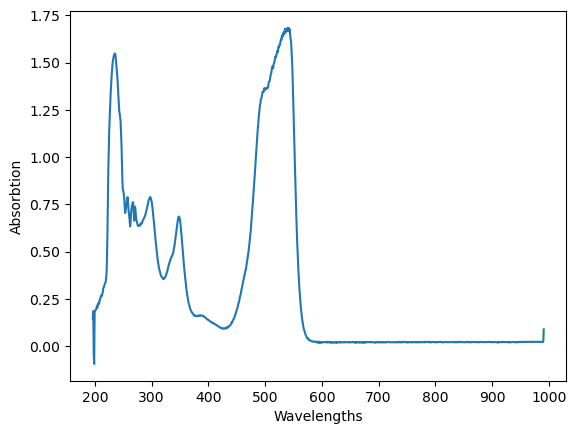

('79fe4fcf-858a-423e-b400-713bfb7332f9',)

In [51]:
RE(qepro.take_uvvis_save_csv2(sample_type='rhodamine', plot=True, csv_path=csv_path, 
                            spectrum_type='Absorbtion', correction_type='Reference', 
                            pump_list=pump_list, precursor_list=precursor_list))

In [73]:
RE(insitu_test(4, 7, csv_path=csv_path, sample='rhodamine', pump_list=pump_list, precursor_list=precursor_list))

LED is Low
UV shutter is High
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200231
LED is Low
UV shutter is High
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200234
LED is Low
UV shutter is High
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200237
LED is Low
UV shutter is High
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200239
UV shutter is Low
LED is High.
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200242
UV shutter is Low
LED is High.
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200245
UV shutter is Low
LED is High.
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200247
UV shutter is Low
LED is High.
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200250
UV shutter is Low
LED is High.
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200253
UV shutter is Low
LED is High.
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200256
UV shutter is Low
LED is High.
QEPro_acquire [In progress. No progress bar available.]                         
QEPro_acquire [In progress. No progress bar available.]                         
                                                                                


/tmp/ipykernel_3430913/2980326845.py:55: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt = datetime.fromtimestamp(unix_time)


20221031,200259


('cc3ea728-447e-47f2-aa7d-4d870c8eee9e',
 '608217ec-14a3-4a39-8360-bf3644848099',
 'd3501f31-7405-4804-9a40-ecacadc0fb93',
 '6af80f04-16a1-4133-a307-5873ae9cd62b',
 '531e3478-3a38-4fd6-8ce5-fd9b14c5341d',
 '6db9db96-41db-4004-a0ef-1c69501d45a8',
 '8e71fe15-048e-46b8-97c6-19db47af0c93',
 '187cf079-0b15-482d-a461-d3142092d8d8',
 'c4cbe7f9-f36f-43c9-a3ad-28a04ef6b53d',
 '8b39d0b6-ef07-4d33-9a37-27a7a84faf09',
 '5e3c3c70-7e7f-4d91-836e-31e579939226')

In [17]:
uid = '5e3c3c70-7e7f-4d91-836e-31e579939226'
db[uid].xarray()['QEPro_serial'].values[0]



'QEP02875'

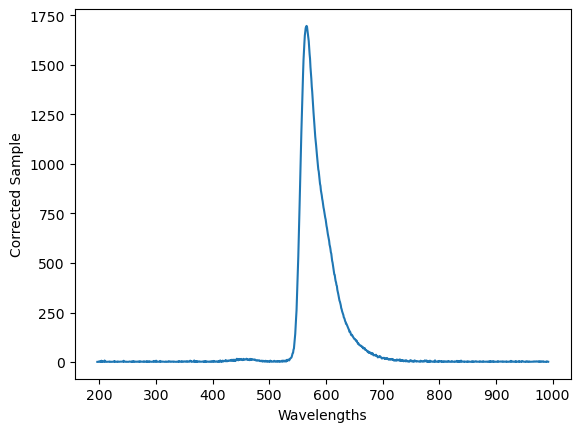

In [69]:
qepro.plot_spectra()

In [ ]:
def h5_rate_spectra(h5_path, h5_name, pump_list, precursor_list, absor=qepro, xray=det4, delay=None):

    fout = h5_path + h5_name
    t_q = list(absor.read().items())[0][1]['timestamp']
    dt = datetime.fromtimestamp(t_q)

    
    with h5py.File(fout, 'w') as hf:
        hf.create_dataset('Time_QEPro', data=[f'{dt.year}{dt.month:02d}{dt.day:02d}', f'{dt.hour:02d}{dt.minute:02d}{dt.second:02d}'])
        hf.create_dataset('Wavelength', data=absor.x_axis.get())
        hf.create_dataset('Dark', data=absor.dark.get())
        if absor.spectrum_type.get(as_string=True) == 'Absorbtion':           
            hf.create_dataset('Reference', data=absor.reference.get())
            hf.create_dataset('Sample_UV', data=absor.sample.get())
            hf.create_dataset('Abosrbance', data=absor.output.get())
        else:
            hf.create_dataset('Sample_PL', data=absor.sample.get())
            hf.create_dataset('PL', data=absor.output.get())            
        for pump, precursor in zip(pump_list, precursor_list):
            hf.create_dataset(pump.name, data=[f'{precursor}', f'{pump.read_infuse_rate.get()}', 
                                               pump.read_infuse_rate_unit.get()])      
    print(f'{fout} is saved.')
    hf.close()

    

    
def csv_rate_spectra(csv_path, csv_name, pump_list, precursor_list, absor=qepro, xray=det4, delay=None):

    fout = csv_path + csv_name
    t_q = list(absor.read().items())[0][1]['timestamp']
    dt = datetime.fromtimestamp(t_q)
    
    with open(fout, 'w') as fp:
        for pump, precursor in zip(pump_list, precursor_list):
            fp.write(f'{pump.name},{precursor},{pump.read_infuse_rate.get()},{pump.read_infuse_rate_unit.get()}\n')        
        
        fp.write(f'Time_QEPro,{dt.year}{dt.month:02d}{dt.day:02d},{dt.hour:02d}{dt.minute:02d}{dt.second:02d}\n')
        x_axis_data = absor.x_axis.get()
        output_data = absor.output.get()
        sample_data = absor.sample.get()
        dark_data = absor.dark.get()
        reference_data = absor.reference.get()
        if absor.spectrum_type.get(as_string=True) == 'Absorbtion':
            fp.write('Energy,Dark,Reference,Sample,Absorbance\n')
        else:
            fp.write('Energy,Dark,Raw Sample,PL\n')

        for i in range(len(output_data)):
            if absor.spectrum_type.get(as_string=True) == 'Absorbtion':
                fp.write(f'{x_axis_data[i]},{dark_data[i]},{reference_data[i]},{sample_data[i]},{output_data[i]}\n')
            else:
                fp.write(f'{x_axis_data[i]},{dark_data[i]},{sample_data[i]},{output_data[i]}\n')

        print('Done.')


In [ ]:
h5_path = '/nsls2/users/clin1/Documents/Cheng-Hung/temp/'
h5_name = '20220912_test6.h5'
h5_rate_spectra(h5_path, h5_name, pump_list, precursor_list, absor=qepro)

In [ ]:
csv_path = '/nsls2/users/clin1/Documents/Cheng-Hung/temp/'
csv_name = '20220912_test3.csv'
csv_rate_spectra(csv_path, csv_name, pump_list, precursor_list, absor=qepro)

In [ ]:
f = '/nsls2/users/clin1/Documents/Cheng-Hung/temp/20220912_test2.csv'
df = pd.read_csv(f, skiprows=3)
df

In [ ]:
b = list(dds1_p1.read().items())
b[0][1]['timestamp']
dt = datetime.fromtimestamp(b[0][1]['timestamp'])
dt?

In [ ]:
dds1_p1.name

In [ ]:
for pump, precursor in zip(pump_list, precursor_list):
    print(pump.name)
    data=[f'{precursor}', pump.read_infuse_rate.get(), pump.read_infuse_rate_unit.get()]
    print(data)